### 1. Introduction


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter
#컨테이너(str, tuple, list, dict, set)에 동일한 값의 자료가 몇개인지를 파악하는데 사용하는 객체
#결과값은 딕셔너리 형태로 출력
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
#사이킷런(scikit-learn): 머신러닝 분석에 유용한 라이브러리
#1.지도학습, 비지도학습 모듈, 2.모델 선택 및 평가 모듈, 3.데이터 변환 및 불러오기 모듈, 4.계산성능 향상 모듈
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm  import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

#import warnings #경고 제어 패키지
#warnings.filterwarnings('ignore') #실행되는 것들 경고 무시

sns.set(style='white', context='notebook', palette='deep')


#import LogisticRegression ImportError: cannot import name 'GradienBoostingClassifier' from 'sklearn.ensemble'
#모듈 버전 충돌의 문제일 것으로 추정됨.

### 2. Load and Check data
2.1 Load data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
IDtest = test["PassengerId"]

2.2 Outlier detection

In [3]:
#2.2 Outlier detection
def detect_outliers(df, n, features):
    outlier_indices=[]
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3-Q1
        outlier_step =1.5*IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
        #append()와의 차이점: append()는 리스트 마지막에 요소 추가, extend()는 요소 내 개별 인자들을 리스트에 추가
        #각 컬럼에서 이상치들의 index들이 outlier_indices()에 들어감(중복가능)
        
    outlier_indices = Counter(outlier_indices) #이상치 개수를 딕셔너리 형태로 출력 ("index":"이상치 개수" )
    multiple_outliers = list(k for k, v in outlier_indices.items() if v>n)
    ##한 탑승객이 n개의 열을 초과하는 열에서 이상치를 보이는 경우
    return multiple_outliers
    #indentation 주의
    
Outliers_to_drop = detect_outliers(train, 2, ["Age", "SibSp", "Parch", "Fare"])
#Age, SibSp, Parch, Fare 열 중 2개 초과하는 열에서 이상치를 보이는 승객

In [4]:
#참고: append() vs extend()
list = [2,9,3]
list.append([1,2,3])
print(list)
list.extend([1,2,3])
print(list)

[2, 9, 3, [1, 2, 3]]
[2, 9, 3, [1, 2, 3], 1, 2, 3]


In [5]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [6]:
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)
#axis=0 일 때 행 제거
#인덱스 열을 버림

2.3 Joining train and test set - 테스트 표본의 수가 적기 때문

In [7]:
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

#concat(): 인자로 주어진 배열이나 값들을 기존 배열에 합쳐서 새 배열을 반환
#axis=0 이므로 행추가(세로 방향으로 길어지게 합침)

2.4 check for null and missing values

In [8]:
#dataset = dataset.fillna(np.nan) 
#결측치를 NaN으로 채움 -> test set에는 survived 열이 없기 때문
#그러나 안해도 똑같이 나오더라

dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [9]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [12]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


### 3. Feature analysis

3.1 Numerical values

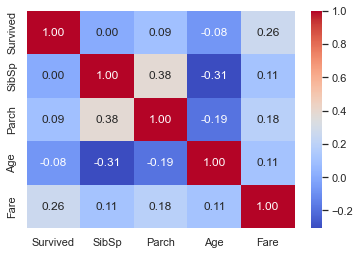

In [13]:
g = sns.heatmap(train[["Survived", "SibSp", "Parch", "Age", "Fare"]].corr(), annot=True, fmt=".2f", cmap="coolwarm")
# Survived와 상관계수 높은 것은 Fare

SibSP

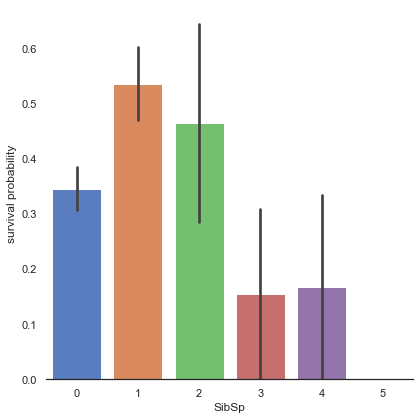

In [14]:
g = sns.catplot(x="SibSp", y="Survived", data=train, kind="bar", height=6, palette = "muted")
#오류: factorplot-> catplot, size->height으로 이름 바뀌었다고 함
g.despine(left=True)
# 왼쪽 테두리선 제거
g = g.set_ylabels("survival probability")

#검은 막대는 '신뢰구간' 의미

Parch

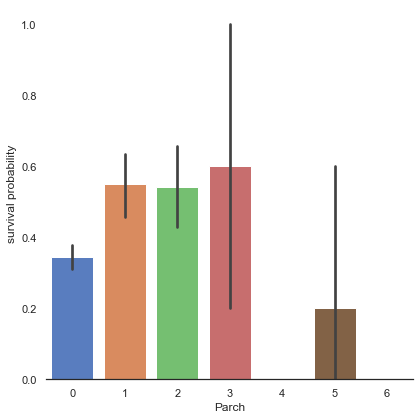

In [15]:
g = sns.catplot(x="Parch", y="Survived", data=train, kind="bar", height=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Age

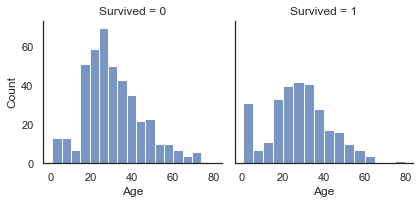

In [16]:
g = sns.FacetGrid(train, col='Survived')
#객체(facet)의 map 메서드에 그릴 그래프의 종류와 종류에 맞는 컬럼 전달
g = g.map(sns.histplot,'Age')
#오류: distplot->displot or histplot
#추세선 안그려짐

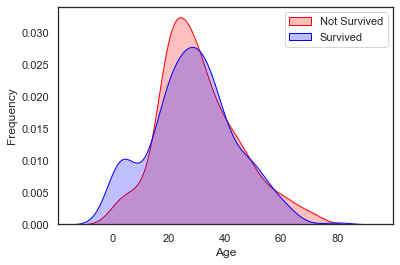

In [17]:
g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1)&(train['Age'].notnull())], ax=g, color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

#kdeplot: 커널밀도추정(kernel density estimate)

Fare

In [18]:
dataset['Fare'].isnull().sum()

1

In [19]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())
#결측치 1개 뿐이므로 평균대치해도 큰 문제 없음

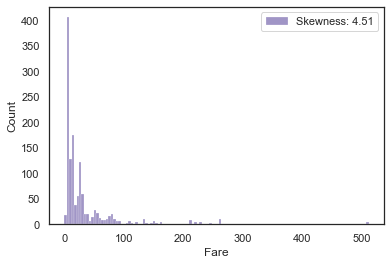

In [20]:
g = sns.histplot(dataset['Fare'], color='m', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

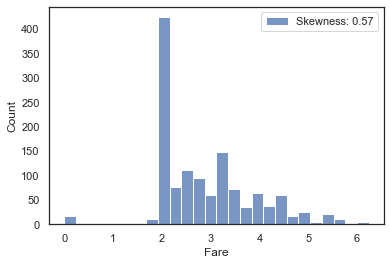

In [21]:
#왜도 보정방법 : 로그변환 - 이유? : 꼬리 값을 분석에 반영시키기 위해
dataset['Fare']= dataset['Fare'].map(lambda i: np.log(i) if i> 0 else 0)
g = sns.histplot(dataset['Fare'], color='b', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

3.2 Categorical values

Sex

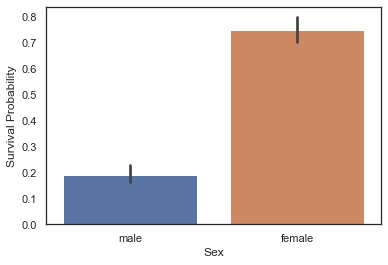

In [22]:
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel('Survival Probability')

In [23]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


Pclass

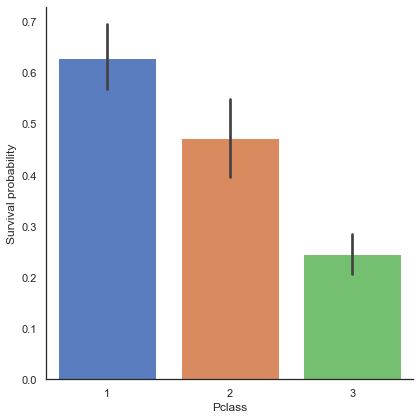

In [24]:
g = sns.catplot(x='Pclass', y='Survived', data=train, kind='bar', height=6, palette = 'muted')
g.despine(left=False)
g = g.set_ylabels('Survival probability')

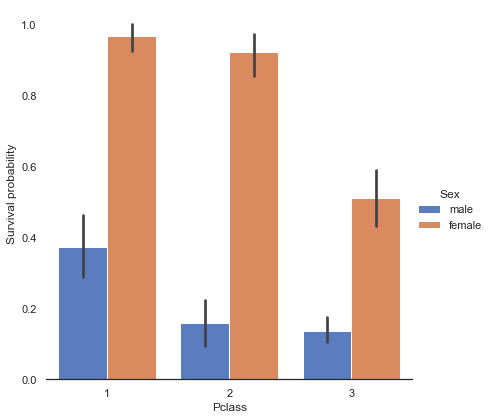

In [25]:
g = sns.catplot(x='Pclass', y='Survived', hue='Sex', data=train, height=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival probability')
# x축과 hue를 바꿔 다르게 표현해볼 수 있음.
# 성별, 객실의 등수는 생존율에 유의미한 영향을 미치는 것을 알 수 있다. 

Embarked

In [26]:
dataset['Embarked'].isnull().sum()

2

In [27]:
dataset['Embarked'].describe()
#top = 'S'

count     1297
unique       3
top          S
freq       904
Name: Embarked, dtype: object

In [28]:
dataset['Embarked']=dataset['Embarked'].fillna('S')

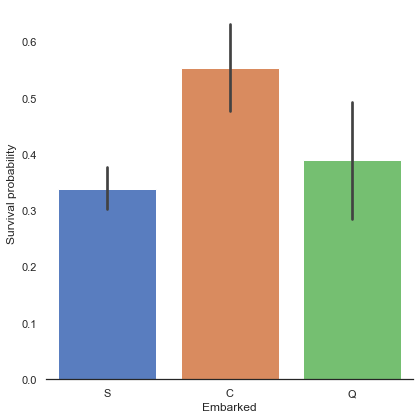

In [29]:
g = sns.catplot(x='Embarked', y='Survived', data=train, height=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival probability')

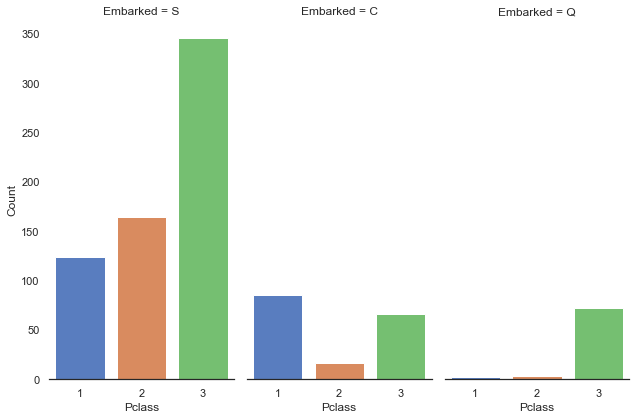

In [30]:
#가설: 다른 항구들에 비해 C항구에서 탑승한 1등석 승객의 비율이 더 높을 것이다.
g = sns.catplot(x='Pclass',col ='Embarked', data=train, height=6, aspect =.5, kind='count', palette='muted')
#오류 떠서 'x=' 추가, 잘 안보여서 aspect=.5 추가
#Aspect ratio of each facet, so that aspect * height gives the width of each facet in inches.
g.despine(left=True)
g = g.set_ylabels('Count')

#평가: 예측과 같이, C항구에서 탑승한 1등석 승객의 비율이 가장 높았고 S, Q항구의 경우 3등석 승객의 비율이 가장 높았다.
#1등석 승객이 우선적으로 대피하였을 것이라는 추정이 가능함. 

### 4. Filling missing Values
4.1 Age

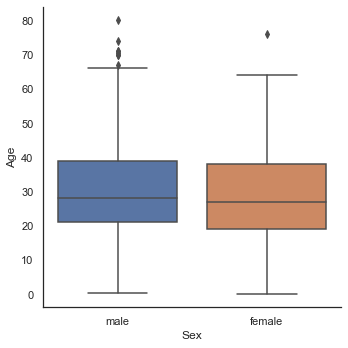

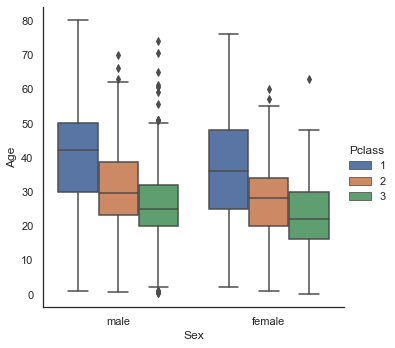

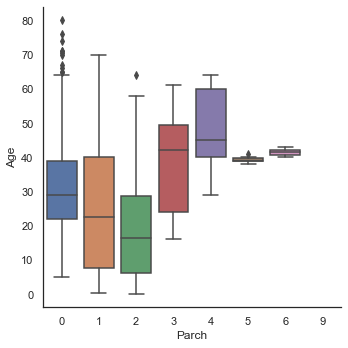

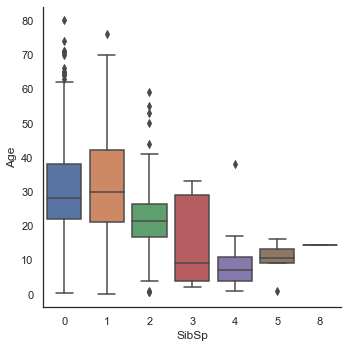

In [31]:
#256개의 샘플에서 나이가 결측치로 도출됨. 어릴수록 더 잘 살아남았을 가능성이 있기 때문에, 이를 확인하기 위해 결측치 대치가 중요한 문제.
#그렇다면, 나이와 상관관계가 가장 높은 변수는 무엇인가? 

g = sns.catplot(y='Age', x='Sex', data=dataset, kind='box')
g = sns.catplot(y='Age', x='Sex', hue='Pclass', data=dataset, kind='box')
g = sns.catplot(y='Age', x='Parch', data=dataset, kind='box')
g = sns.catplot(y='Age', x='SibSp', data=dataset, kind='box')

#성별은 나이와 관련성이 낮다.
#1등석에 가까울수록 나이가 많다.
#부모자식이 많을수록 나이가 많다.
#형제자매, 배우자가 많을수록 나이가 적다.

#boxplot의 장점: 직관적으로 상관관계를 파악할 수 있음.

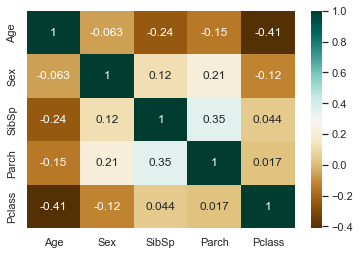

In [32]:
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True)

#나이가 Sibsp, Parch, Pclass 와 상관관계가 높으니 각각의 나이 median으로 결측치를 대치하겠다.

In [33]:
#참고
dataset['Age'][dataset['Age'].isnull()]

#뒷열 값을 앞열에서 index로 갖는 값을 가져와라
#[컬럼][범위지정]

5      NaN
17     NaN
19     NaN
26     NaN
27     NaN
        ..
1289   NaN
1291   NaN
1294   NaN
1297   NaN
1298   NaN
Name: Age, Length: 256, dtype: float64

In [34]:
dataset['Age'].isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
1294     True
1295    False
1296    False
1297     True
1298     True
Name: Age, Length: 1299, dtype: bool

In [35]:
index_NaN_age = dataset['Age'][dataset['Age'].isnull()].index.to_list()
#오류: to_list() 사용해 index를 list로 변환
# 컬럼명[범위지정]....

for i in index_NaN_age:
    age_med = dataset['Age'].median() #전체 Age의 median
    age_pred = dataset['Age'][(dataset['SibSp']== dataset.iloc[i]['SibSp'])
                              &(dataset['Parch']==dataset.iloc[i]['Parch'])
                              &(dataset['Pclass']==dataset.iloc[i]['Pclass'])].median()

#오류: () 괄호 없앴더니 해결됨.
#iloc: integer location. 데이터 프레임의 행이나 칼럼의 순서를 나타내는 정수값 추출
#나이가 NaN인 행의 SisSp값과 같은 값을 갖는 행의 Age들과, 나이가 NaN인 행의 Parch값과 동일한 값을 갖는 행의 Age들과, 
#나이가 NaN인 행의 Pclass값과 같은 값을 갖는 행의 Age들의 중간값

    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

#가능하면 age_pred 넣고 아니면 age_med 넣어라

import warnings
warnings.filterwarnings('ignore')

C:\Users\legra\AppData\Local\Temp\ipykernel_7992\105856667.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
C:\Users\legra\AppData\Local\Temp\ipykernel_7992\105856667.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_med


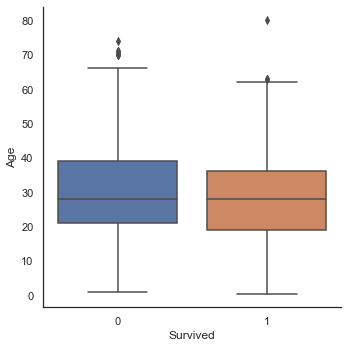

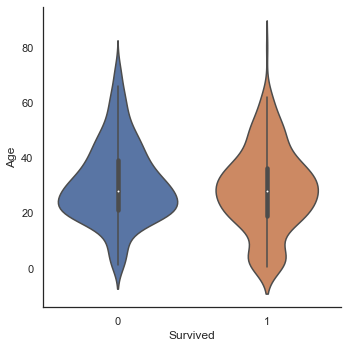

In [36]:
g = sns.catplot(x='Survived', y= 'Age', data=train, kind='box')
g = sns.catplot(x='Survived', y= 'Age', data=train, kind='violin')
# 결과는 동일. 0~10세 이하의 생존율이 높았음을 알 수 있다.

### 5. Feature engineering
5.1 Name/Title

In [37]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [38]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset['Name']]
#, 기준으로 잘라 뒷부분(=두번째) 취하고 . 기준으로 잘라 앞부분(=첫번째) 취하고 양쪽 공백 제거

dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

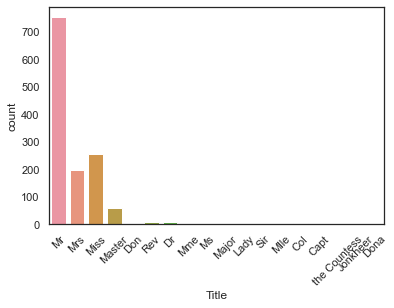

In [39]:
g = sns.countplot(x='Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation =45)
#setp: 필드값 설정(set property), rotation=45: 45도 회전

In [40]:
#범주로 나누기
dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr','Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].map({'Master':0, 'Miss':1, 'Ms':1, 'Mme':1, 'Mlle':1, 'Mrs':1, 'Mr':2, 'Rare':3})
dataset['Title'] = dataset['Title'].astype(int)

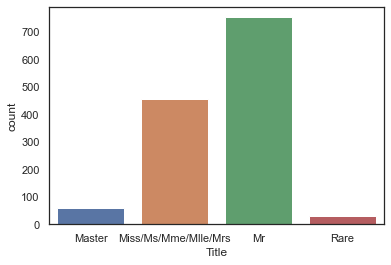

In [41]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master','Miss/Ms/Mme/Mlle/Mrs', 'Mr', 'Rare'])

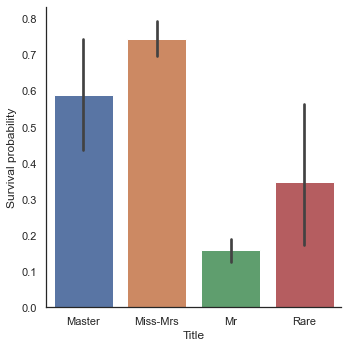

In [42]:
g = sns.catplot(x='Title', y='Survived', data=dataset, kind='bar')
g = g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('Survival probability')

#Woman and Children First

In [43]:
dataset.drop(labels=['Name'], axis=1, inplace=True)
#axis = 1: 열 방향
#inplace = True인 경우 원본 df의 메모리에 그대로 적용됨

5.2 Family size

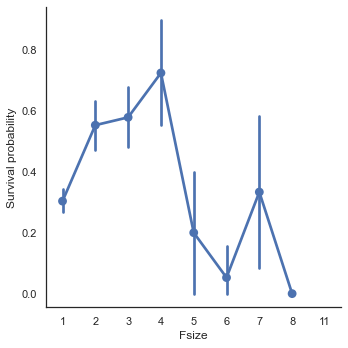

In [44]:
dataset['Fsize'] = dataset['SibSp']+dataset['Parch']+1
g = sns.catplot(x='Fsize', y='Survived', data=dataset, kind='point')
#오류떠서 수정
g = g.set_ylabels('Survival probability')

In [45]:
#범주화
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s ==1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s ==2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s:1 if s>= 5 else 0)

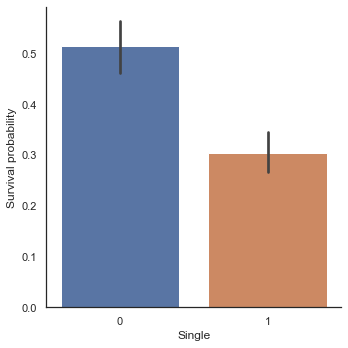

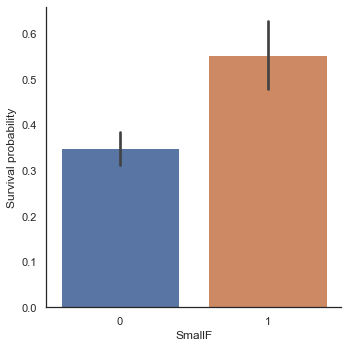

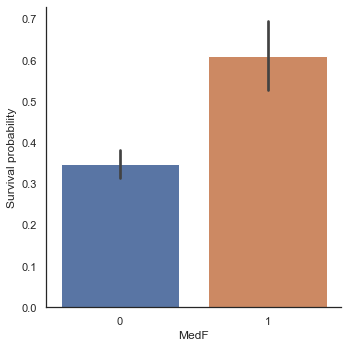

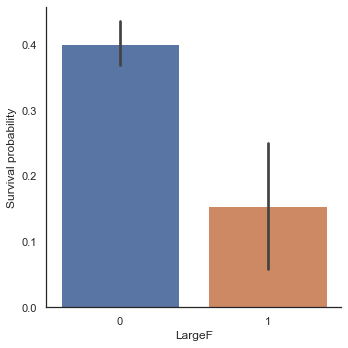

In [46]:
g = sns.catplot(x='Single', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival probability')
g = sns.catplot(x='SmallF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival probability')
g = sns.catplot(x='MedF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival probability')
g = sns.catplot(x='LargeF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival probability')
#가족수가 2~4명일 때 싱글 혹은 대가족인 경우보다 더 잘 살아남았다.

In [47]:
# Title, Embarked를 더미변수화 - 범주형을 '해당하면 1, 아니면 0'으로 수치화해주기 위함 
dataset = pd.get_dummies(dataset, columns = ['Title'])
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix='Em')

In [48]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


5.3 Cabin

In [49]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [50]:
dataset['Cabin'].describe()
#top 다르게 나오는 문제 - 튜토리얼에는 'B57 B59 B63 B66'

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [51]:
dataset['Cabin'].isnull().sum()

1007

In [52]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [53]:
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])
#결측치가 아니면 앞자리(알파벳)를 따오고, 결측치는 X로 대치

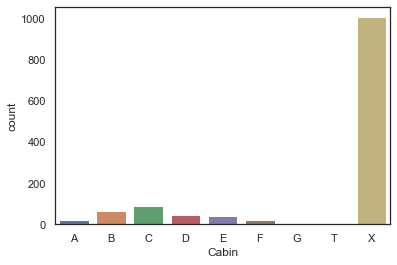

In [54]:
g = sns.countplot(x=dataset['Cabin'], order= ['A','B','C','D','E','F','G','T','X'])

#g = sns.countplot(x="Cabin", data=dataset, order=['A','B','C','D','E','F','G','T','X'])

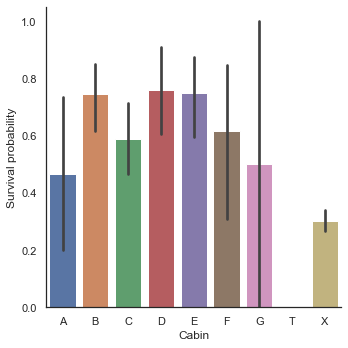

In [55]:
g = sns.catplot(y='Survived', x='Cabin', data=dataset, kind='bar', order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels('Survival probability')

#선실 정보가 있는 승객의 수가 적었기 때문에, 선실 위치별 생존율을 파악하기는 어렵다.
#그러나 선실정보가 있는 승객들이 그렇지 않은 승객들보다 생존율이 높았다. 이는 B, D, E에서 두드러진다.

In [56]:
# Title, Cabin을 더미변수화
dataset = pd.get_dummies(dataset, columns = ['Cabin'], prefix='Cabin')

5.4 Ticket

In [57]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [58]:
#같은 접두사를 가진 티켓은 비슷한 등실과 생존율로 직결될 수 있으므로 티켓변수를 티켓접두사로 대치
Ticket = []
for i in dataset.Ticket.to_list():
    if not i.isdigit():
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) # take prefix
    else:
        Ticket.append('X')

dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [59]:
dataset= pd.get_dummies(dataset, columns = ['Ticket'], prefix='T')

In [60]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
#카테고리로 왜 타입을 바꾸는 걸까?

dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix='Pc')

In [61]:
dataset.drop(labels = ['PassengerId'], axis=1, inplace = True)
#활용하지 않는 변수는 drop한다.
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


### 6. Modeling

In [62]:
#훈련데이터와 테스트데이터를 분리한다.
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'], axis=1, inplace=True)

In [63]:
train['Survived'] = train['Survived'].astype(int)
Y_train = train['Survived']
X_train = train.drop(labels=['Survived'], axis = 1)

6.1 Simple modeling
 - 6.1.1 Cross validate models

In [64]:
# 10개의 대표적인 분류기를 비교, k-fold 교차검증법으로 각 분류기의 정확도를 측정하겠다. 

kfold = StratifiedKFold(n_splits=10)

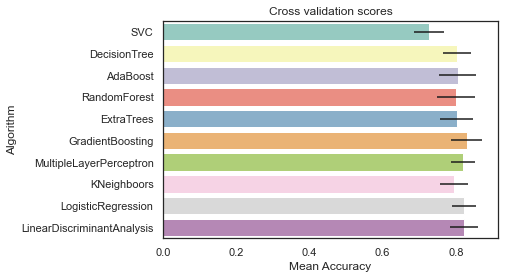

In [65]:
# Modeling step Test differents algorithms 

random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")


#SVC, AdaBoost, RandomForest, ExtraTrees, GradientBoosting 분류기를 조합해 앙상블 모델링을 시도하겠다. 

- 6.1.2 Hyperparameter tunning for best models

In [66]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [67]:
gsadaDTC.best_score_

0.8275536261491316

In [68]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8297369765066394

In [69]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8343079673135854

In [70]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8320097037793668

In [71]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

- 6.1.3 Plot learning curves : 과적합 발생여부 확인

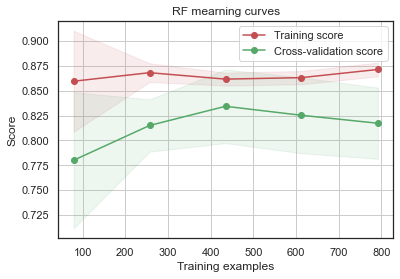

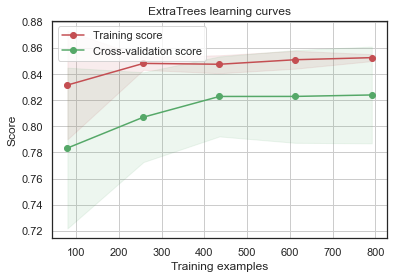

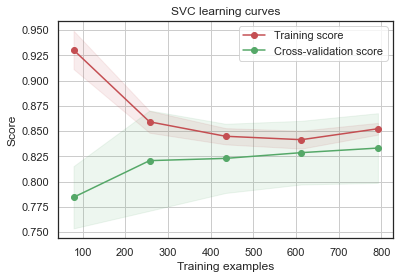

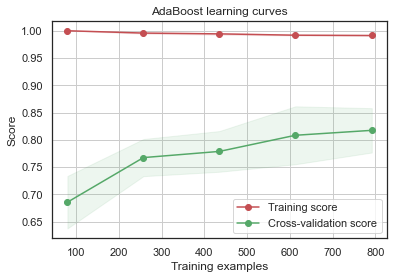

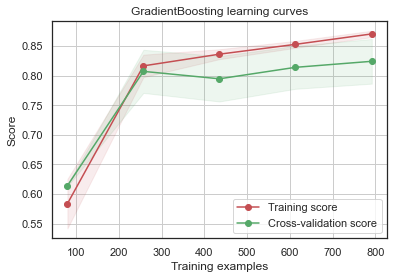

In [72]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

- 6.1.4 Feature importanc of tree based classifiers

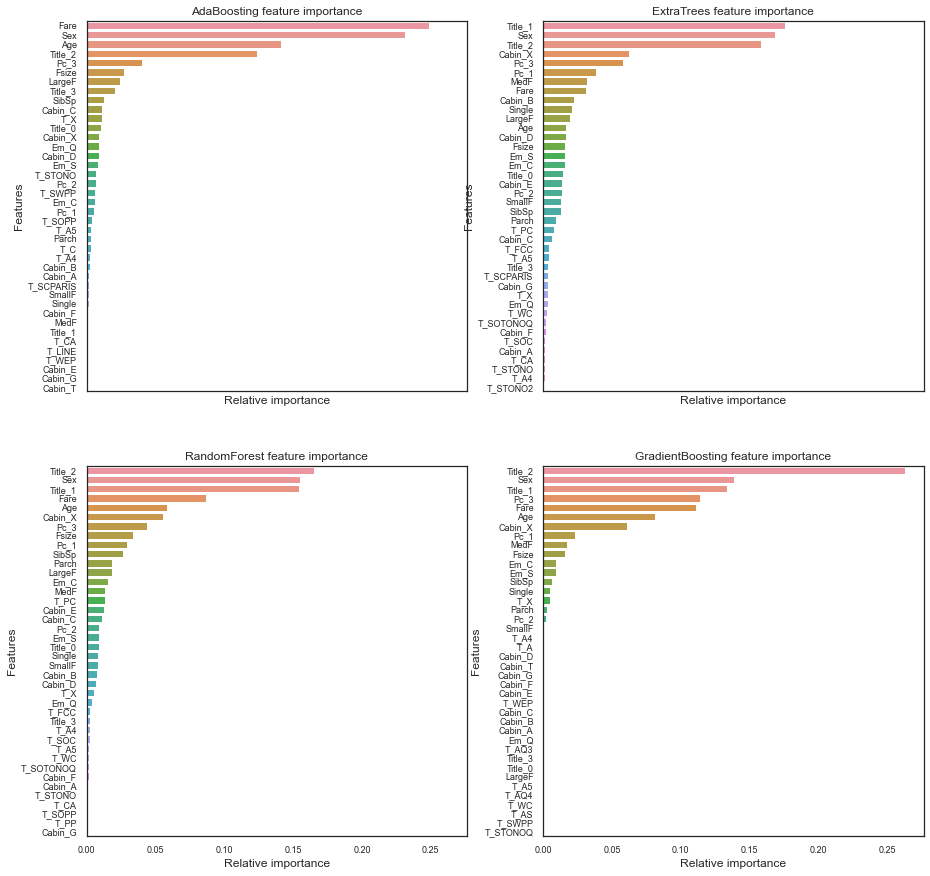

In [73]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

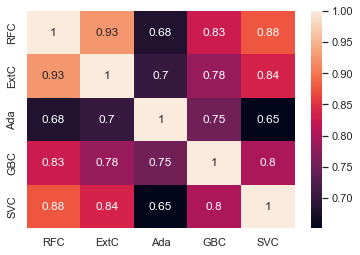

In [74]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

6.2 Ensemble modeling
- 6.2.1 Combining models

In [75]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

6.3 Prediction
- 6.3.1 Predict and Submit results

In [76]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)